In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.datasets import fashion_mnist
from torch.utils.data import dataloader
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

In [7]:
device = torch.device("mps")

In [8]:
(X_train,y_train),(X_test,y_test) = fashion_mnist.load_data()
X_train.shape,y_train.shape

((60000, 28, 28), (60000,))

In [15]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [19]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 1. Plotting a sample image from every class

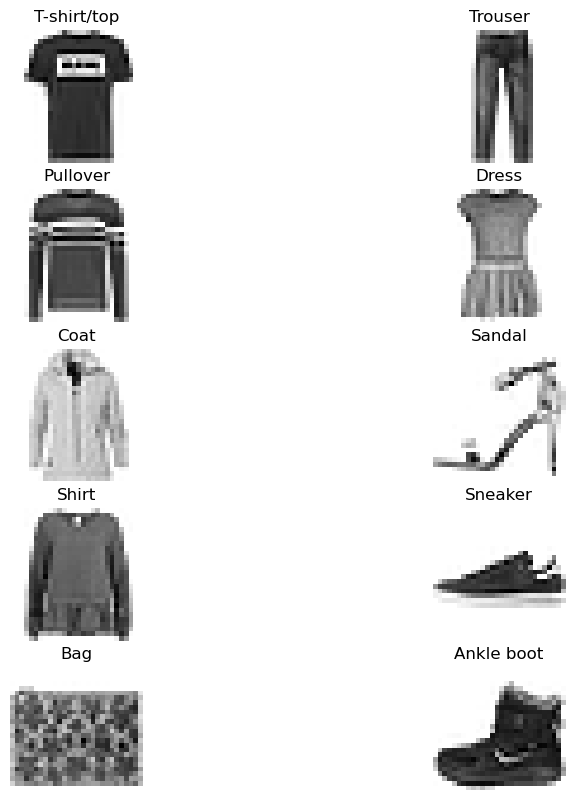

In [23]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
    # Find the first image in the training set with the corresponding label
    index = np.where(y_train == i)[0][0]
    image = X_train[index]
    # Plot the image
    plt.subplot(5, 2, i+1)
    plt.imshow(image, cmap=plt.cm.gray_r)
    plt.title(class_names[i])
    plt.axis('off')
plt.show()